In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from math import cos, sin, pi, sqrt
%matplotlib inline

In [4]:
dmap = np.load("../data/sealion/TrainEllipseDensity/868_5.npz")["dmap"]

In [5]:
dmap_sum = np.sum(dmap, axis=-1)

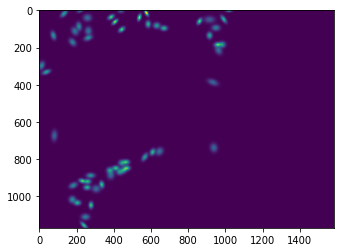

In [6]:
plt.imshow(dmap_sum)

In [7]:
expected_size = [78, 64, 60, 48, 28]

In [8]:
def gaussian2d_gen(x, y, theta, sx=1, sy=1, x0=0, y0=0, A=1):
    """ See https://fr.wikipedia.org/wiki/Fonction_gaussienne
    """    
    assert(sx != 0)
    assert(sy != 0)
    a = (cos(theta)**2) / (2 * sx**2) + (sin(theta)** 2)/ (2 * sy**2)
    b = -sin(2 * theta)/ (4 * sx**2) + sin(2 * theta) / (4 * sy**2)
    c = (sin(theta)**2) / (2 * sx**2) + (cos(theta)** 2)/ (2 * sy**2)
    dx = x - x0
    dy = y - y0
    
    return A * np.exp(-(a * dx**2 + 2 * b * dx * dy + c * dy**2))

In [9]:
def mask_gaussian(major, minor, theta):
    """ See http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/ for the 5.991
    """
    df = 4.605 #5.991
    sigma_x = major/(2 * sqrt(df))
    sigma_y = minor/(2 * sqrt(df))
    half = int((max(sigma_x, sigma_y) * 3.5 ))  # to be sure that the limit of the mask have a value close to 0 (avoid artifact on density map)
    im = np.zeros((2 * half + 1, 2 * half + 1), np.float32)
    for y in range(-half, half + 1):
        for x in range(-half, half + 1):
            im[y + half, x + half] = gaussian2d_gen(x, y, theta, sigma_x, sigma_y, 0, 0, 1)
    total_sum = np.sum(im)
    im /= total_sum
    return im

In [10]:
def get_threshold_values(expected_size):
    thresholds = []
    for s in expected_size:
        gaussian = mask_gaussian(s, s//2, pi/2)
        im = np.zeros(gaussian.shape, dtype=np.uint8)
        e = ((gaussian.shape[1]//2, gaussian.shape[0]//2), (s, s//2), 90)
        im = cv2.ellipse(im, e, color=(255, 255, 255), thickness=-1)
        threshold = np.max(gaussian[im == 0])
        thresholds.append(threshold)
    return thresholds

In [11]:
thresholds = get_threshold_values(expected_size)

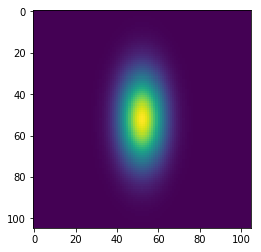

In [12]:
g = mask_gaussian(64, 64/2, pi/2)
plt.imshow(g)

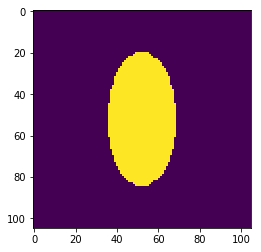

In [24]:
im = np.zeros(g.shape, dtype=np.uint8)
e = ((g.shape[0]//2, g.shape[0]//2), (64, 64/2), 90)
im = cv2.ellipse(im, e, color=(255, 255, 255), thickness=-1)
plt.imshow(im)

In [25]:
np.max(g[im == 0])

0.00013692187

In [15]:
np.max(g)

0.0014320769

In [26]:
def convert_dmap(dmap, thresholds):
    n_sealion_types = 5
    
    # Rescale between layer, due to different gaussians.
    # Rescale is done so that the threshold on each layer is 1.
    rescale = 1/np.asarray(thresholds)
    dscaled = dmap * rescale
    
    # Keep only one non-zero value per pixel
    dmax = np.argmax(dscaled, axis=-1)
    for i in range(n_sealion_types):
        dscaled[dmax!=i, i] = 0
    
    # Thresholds differs due to the different size of the gaussians
    dmap_thresholded = (dscaled > 1)
    
    # Compute the background layer
    dsum = np.sum(dmap_thresholded, axis=-1)
    dbackground = dsum == 0
    
    # Merge the background layer
    dmerge = np.concatenate((dmap_thresholded, np.expand_dims(dbackground, axis=-1)), axis=-1)
    return np.argmax(dmerge, axis=-1).astype(np.int8)

In [27]:
smap = convert_dmap(dmap, thresholds)

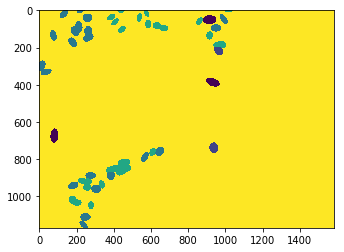

In [28]:
plt.imshow(smap)

In [30]:
def to_img(smap):
    colors_rgb = [(1, 7, 179), (178, 12, 178), (5, 41, 79), (177, 54, 26), (26, 171, 43)]
    im = np.zeros(smap.shape + (3, ), dtype=np.uint8)
    for i in range(5):
        im[smap==i, :] = colors_rgb[i]
    return im

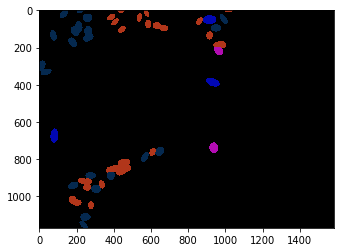

In [31]:
im_map = to_img(smap, colors_rgb)
cv2.imwrite("../data/map.png", im_map)
plt.imshow(im_map)

In [32]:
root_dir = "/home/lowik/sealion/data/sealion/"

In [36]:
def create_segmentation_maps(root_dir, thresholds):
    dmap_dir = os.path.join(root_dir, "TrainEllipseDensity")
    smap_dir = os.path.join(root_dir, "TrainSegmentation")
    os.makedirs(smap_dir, exist_ok=True)
    for fn in os.listdir(dmap_dir):
        dmap = np.load(os.path.join(dmap_dir, fn))["dmap"]
        smap = convert_dmap(dmap, thresholds)
        np.savez_compressed(os.path.join(smap_dir, fn), smap=smap)

In [39]:
create_segmentation_maps(root_dir, thresholds)

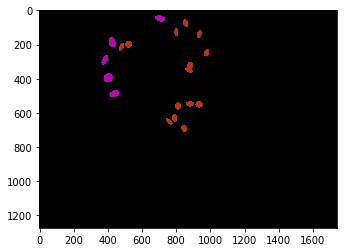

In [40]:
smap = np.load("../data/sealion/TrainSegmentation/206_9.npz")["smap"]
im_map = to_img(smap, colors_rgb)
cv2.imwrite("../data/map.png", im_map)
plt.imshow(im_map)